# STEP ONE: LOAD AND INSPECT OUR DATA

In [38]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
import requests

# Ensure plots show inline
%matplotlib inline


In [39]:
# Config
DATA_PATH = "data/customer_support_tickets_dirty_500.csv"
DATA_URL = "https://raw.githubusercontent.com/Shaddynetwork/Thrive_Internship_ML_A/main/customer_support_tickets_dirty.csv"
RANDOM_SEED = 42

In [40]:
# Ensure data folder exists
os.makedirs("data", exist_ok=True)
# Check if file exists, otherwise download
if not os.path.exists(DATA_PATH):
    print("Dataset not found locally. Downloading from GitHub...")
    r = requests.get(DATA_URL)
    open(DATA_PATH, "wb").write(r.content)
    print("Download complete.")


Dataset not found locally. Downloading from GitHub...
Download complete.


In [41]:
# Loading dataset
df = pd.read_csv(DATA_PATH)

In [42]:
df.head()

,text,label,ticket_id,agent_name
0,Where can I find API rate limits documentation?,Othr,1000,Dana
1,Can I migrate data from Freshdesk?,Othr,1001,Bob
2,Cannot update billing address; page keeps relo...,billing,1002,Charlie
3,Looking for a product roadmap or upcoming feat...,other,1003,Dana
4,Dark mode toggled but UI stays light.,Tech-support,1004,Alice


In [43]:
# inspecting Dataset
df.head(20)

,text,label,ticket_id,agent_name
0,Where can I find API rate limits documentation?,Othr,1000,Dana
1,Can I migrate data from Freshdesk?,Othr,1001,Bob
2,Cannot update billing address; page keeps relo...,billing,1002,Charlie
3,Looking for a product roadmap or upcoming feat...,other,1003,Dana
4,Dark mode toggled but UI stays light.,Tech-support,1004,Alice
5,Promo code SPRING15 not applied at checkout.,billing,1005,Alice
6,Incorrect role assigned; need admin access for...,account,1006,Dana
7,File export to CSV generates corrupted file.,technical,1007,Dana
8,Overcharged by GHS 120 on my last bill. 😡,billing,1008,Dana
9,NaN,account,1009,Dana


In [44]:
df.shape

(520, 4)

In [45]:
# checking number of rows and columns our dataset has
row = df.shape[0]
column = df.shape[1]
print(f"The dataset has {row} rows and {column} columns")

The dataset has 520 rows and 4 columns


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        495 non-null    object
 1   label       495 non-null    object
 2   ticket_id   520 non-null    int64 
 3   agent_name  520 non-null    object
dtypes: int64(1), object(3)
memory usage: 16.4+ KB


In [47]:
# Checking for Missing values in the dataset
df.isnull().sum()

text          25
label         25
ticket_id      0
agent_name     0
dtype: int64

In [48]:
# checking for duplicate rows
duplicated_count = df.duplicated().sum()
print(f"Total number of duplicate rows are: {duplicated_count}")

Total number of duplicate rows are: 0


## **Findings** **from** **Data** **Inspection**

From the initial inspection, we observed the following:

The dataset contains ***520 rows*** and **4 columns**.   
There are **missing values** in two key columns: 'text' and 'label'.  
Several **misspellings** and ***inconsistent letter casing*** were detected in the 'label' column (as seen in 'df.head(20)').  
 **No duplicate rows** were found in the dataset.  

These findings highlight the need for thorough data cleaning before model training  particularly to handle missing entries, normalize label names, and ensure consistent text formatting.


# **STEP 2**: **DATA** **CLEANING**
1. Removing Missing Values
2. Normalized labels to the four core classes:  
   - `billing`  
   - `technical`  
   - `account`  
   - `other`
3. Fixed inconsistencies like typos (`Billng` → `billing`, `Tech-support` → `technical`, etc.).

4. Cleaned text by removing URLs, hashtags, mentions, emojis, and extra spaces.  

5. Converted all text to lowercase and removed HTML entities.


In [49]:
#Dropping Missing values
df.dropna(inplace =True)

In [50]:
#checking for missing value
df.isnull().sum()

text          0
label         0
ticket_id     0
agent_name    0
dtype: int64

In [51]:
df['label'].value_counts()

label
Accnt           41
 Tech           38
ACCOUNT         36
Othr            35
Billng          34
Other           33
other           32
technical       31
Billing         31
TECHNICAL       30
billing         25
OTHER           25
BILLING         23
Tech-support    20
 Account        20
account         18
Name: count, dtype: int64

In [52]:
#change all to lowercase and remove space
df['label'] = df['label'].str.lower().str.strip()

In [53]:
df['label'].value_counts()

label
other           90
billing         79
account         74
technical       61
accnt           41
tech            38
othr            35
billng          34
tech-support    20
Name: count, dtype: int64

In [54]:
#mapping labels in four class
label_mapping = {
    'billing': 'billing',
    'billng' : 'billing',
    'billing': 'billing',
    'technical': 'technical',
    'tech-support':'technical',
    'tech' : 'technical',
    'account': 'account',
    'accnt' : 'account',
    'other': 'other',
    'othr': 'other'

}
df['label'] = df['label'].replace(label_mapping)

In [55]:
# Inspecting the attribute labels to know number of unique values
class_labels = df['label'].nunique()
class_name = df['label'].unique()
print(f"The Normalize labels has {class_labels} classes, namely: {class_name}")

The Normalize labels has 4 classes, namely: ['other' 'billing' 'technical' 'account']


### Still on **data** **cleaning**, so far we've normalized our labels into four classes. Also, we have addressed the typos and inconsistencies in the dataset.
### Now moving to removing URLs and emojis, before that we want to know all records with URLs and emojis
## Importing re: To allow us clean urls from our text


In [56]:
# IDENTIFY NOISY SYMBOLS AND HTML TAGS
df['has_weird_symbol'] = df['text'].str.contains(r'[~^|<>]', regex=True)
df[df['has_weird_symbol']].head(5)

,text,label,ticket_id,agent_name,has_weird_symbol
47,Can't verify phone number; code not sent. <br>,account,1047,Dana,True
70,Please provide onboarding training for my team...,other,1070,Bob,True
117,App crashes when I tap Save on Android. <br>,technical,1117,Bob,True
141,Can't verify phone number; code not sent. <br>,account,1141,Dana,True
190,Overcharged by $49 on my last bill. <br>,billing,1190,Bob,True


In [57]:
#identify symbols and non-word charater
df['symbol_context'] = df['text'].str.extract(r'(\W{2,})')
print(df['symbol_context'].value_counts())

symbol_context
;        55
 #       20
. ###    17
 /       16
. 😡      14
.        14
. !!!    13
. <      11
%        10
 $        8
?         5
? !!!     5
? 😡       3
? ###     2
Name: count, dtype: int64


In [58]:
import re
# Find rows the contains URLs pattern
url_pattern = r'http\S+|www\S+'
url_df = df[df['text'].str.contains(url_pattern)]
print(f"Number of rows with URLs: {len(url_df)}")


Number of rows with URLs: 0


In [59]:
# Find rows that contain mentioned and hashtag patterns
mention_hashtags = r'[@#]\w+'
hashtags_df = df.loc[df['text'].str.contains(mention_hashtags, na=False)]
print(f"Number of rows with mentioned hashtags: {len(hashtags_df)}")

Number of rows with mentioned hashtags: 28


In [60]:
# Locating emojis patterns
emoji_pattern = r'[\U00010000-\U0010ffff]'
emoji_df = df.loc[df['text'].str.contains(emoji_pattern, na=False)]
print(f"Number of rows with emojis: {len(emoji_df)}")

Number of rows with emojis: 22


In [61]:
# Find texts with extra spaces
spaces_df = df[df['text'].str.contains(r'\s{2,}', regex=True, na=False)]
print(f"Rows with extra spaces: {len(spaces_df)}")



Rows with extra spaces: 0


### We have successfully identified that some of the records have emojis and hastags or mentioned.
### We proceed to removing them
#### To remove emojis we need to install emoji

In [62]:
%pip install emoji

Note: you may need to restart the kernel to use updated packages.


In [63]:
import emoji

def remove_emojis(text):
    if not isinstance(text, str):
        return ""
    return emoji.replace_emoji(text, replace='')


In [64]:
df['text'] = df['text'].apply(remove_emojis)

### Below is a function to remove all noise in the 'text' column

In [65]:
import html

def cleaning_text(text):
  """Removing emojis, hashtags,
  and other regex in the text """

  if not isinstance(text, str):
    return ""


 #Replace multiple spaces with a single one
  text = re.sub(r'\s+', ' ', text).strip()


  # Remove HTML tags like <br>, <p>, etc.
  text = re.sub(r'<.*?>', ' ', text)

  # Decode HTML entities (&amp;, &lt;, etc.)
  text = html.unescape(text)


  # removing hashtags and mentions
  text = re.sub(r'[@#]\w+', '', text)
  #removing #
  text = re.sub(r'#+', '', text)

  #removing "/\"
  text = re.sub(r'\\', '', text)
  text = re.sub(r'/', '', text)

  # Remove everything else
  text = re.sub(r'[^A-Za-z0-9\s.,!?$₵%:;\'"-]', ' ', text)

  #removing extra spaces
  text = re.sub(r'\s{2,}', ' ', text)

  return text

In [66]:
#Applying cleaning_text to df['text']
df['text'] = df['text'].apply(cleaning_text)

In [67]:
#inspecting if changes took effect
df['text'].tail(30)

487                 Need to merge two accounts into one.
488    Incorrect role assigned; need admin access for...
489                  Overcharged by $49 on my last bill.
492                  Overcharged by $49 on my last bill.
493    Subscription renewal charged incorrectly this ...
494           Locked out after too many login attempts. 
496                Website returns 500 error on profile.
497    Subscription renewal charged incorrectly this ...
498                   Charged twice for the same order .
499           Integration with Slack fails with timeout.
500                How can I request my data under GDPR?
501               Website returns 500 error on checkout.
502    Requesting invoice to be sent monthly instead ...
503        Upload stuck at 99% for more than 10 minutes.
504     Forgot my password and reset link never arrives.
505      Please provide onboarding training for my team.
506      Please provide onboarding training for my team.
507     Profile picture upload 

## Done with cleaning our data, proceeding to Exploratory Findings
## 🔍 Exploratory Findings

### 1. Label Distribution
- The dataset shows **moderate class imbalance**, with “Other” and “Technical” being slightly dominant.  
- Distribution insights guide **stratified sampling** during model training to maintain fairness.

label
other        125
technical    119
account      115
billing      113
Name: count, dtype: int64


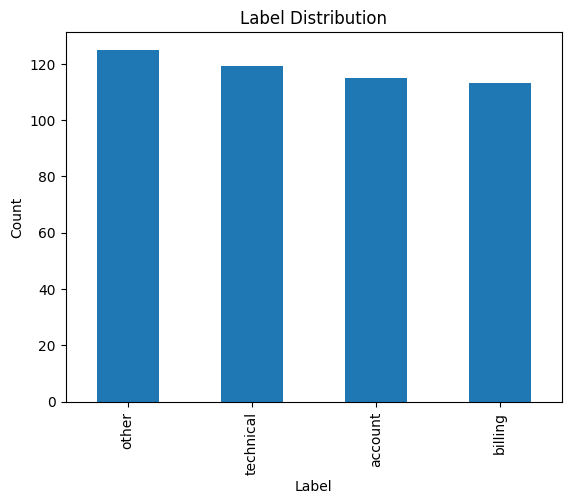

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
print(df['label'].value_counts())

# Plotting bar chart to know the distirbution of each class in the label class
df['label'].value_counts().plot(kind = 'bar', )
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

# Next is Text Analysis

In [69]:
#Calculate text lengths (in words)
# Convert each text to string and split into words, then count them
text_length = df["text"].astype(str).apply(lambda x: len(x.split()))

# Print summary statistics
print("Text length (in words): Summary statistics:")
print(text_length.describe())


Text length (in words): Summary statistics:
count    472.000000
mean       7.381356
std        1.081946
min        5.000000
25%        7.000000
50%        7.000000
75%        8.000000
max       10.000000
Name: text, dtype: float64


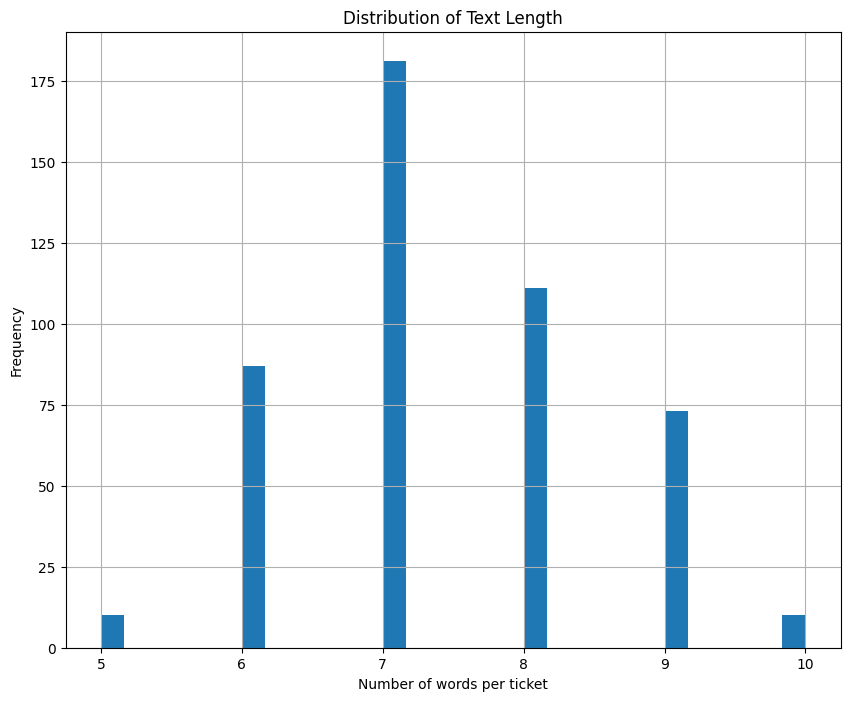

In [70]:
#plotting Test Statistics
plt.figure(figsize=(10,8))
text_length.hist(bins=30)
plt.title('Distribution of Text Length')
plt.xlabel('Number of words per ticket')
plt.ylabel('Frequency')
plt.show()

In [71]:
# dropping two added columns
df.drop(['has_weird_symbol', 'symbol_context'], axis=1, inplace = True)

In [72]:
df.head()

,text,label,ticket_id,agent_name
0,Where can I find API rate limits documentation?,other,1000,Dana
1,Can I migrate data from Freshdesk?,other,1001,Bob
2,Cannot update billing address; page keeps relo...,billing,1002,Charlie
3,Looking for a product roadmap or upcoming feat...,other,1003,Dana
4,Dark mode toggled but UI stays light.,technical,1004,Alice


In [73]:
if set(["text","label"]).issubset(df.columns):
    def sample_per_class(dataframe, col_label="label", n=3):
        samples = []
        for cls, group in dataframe.groupby(col_label):
            s = group.sample(min(n, len(group)), random_state=RANDOM_SEED)[["text", col_label]]
            s.insert(0, "sample_of", cls)
            samples.append(s)
        return pd.concat(samples, ignore_index=True)

    samples_df = sample_per_class(df, "label", n=3)
    display(samples_df)
else:
    print("Skipping samples per class — missing 'text' or 'label'.")

,sample_of,text,label
0,account,Profile picture upload fails with unknown error.,account
1,account,How do I delete my account and all data?,account
2,account,Profile picture upload fails with unknown error.,account
3,billing,Subscription renewal charged incorrectly this ...,billing
4,billing,Promo code SAVE20 not applied at checkout.,billing
5,billing,Currency converted incorrectly; expected GBP.,billing
6,other,Do you offer discounts for students or NGOs?,other
7,other,Please provide onboarding training for my team.,other
8,other,Requesting invoice to be sent monthly instead ...,other
9,technical,File export to CSV generates corrupted file.,technical


In [74]:
df.to_csv("../data/clean/clean_tickets.csv", index=False)

# Summary of Data Exploration and Preprocessing

This notebook covers the initial steps of exploring and cleaning the Customer Support Ticket Dataset.

## 1. Data Loading and Inspection

- The dataset was loaded from a CSV file.
- Initial inspection revealed 520 rows and 4 columns.
- Missing values were identified in the 'text' and 'label' columns (25 in each).
- No duplicate rows were found.
- Inconsistent labeling (typos, casing, and spacing) was observed in the 'label' column.

## 2. Data Cleaning

- Missing values were dropped from the dataset.
- Labels were normalized to four core classes: `billing`, `technical`, `account`, and `other`. This involved:
    - Converting labels to lowercase and removing leading/trailing spaces.
    - Mapping variations (e.g., 'Accnt', 'Tech-support', 'Othr') to the standardized classes.
- Text cleaning was performed on the 'text' column to remove noise:
    - HTML tags were removed.
    - HTML entities were decoded.
    - Mentions and hashtags were removed.
    - Emojis were removed.
    - Extra spaces were removed.

## 3. Exploratory Findings

- **Label Distribution:** Analysis showed a moderate class imbalance among the four normalized labels, with 'other' and 'technical' being slightly more frequent.
- **Text Analysis:** Calculated the length of each text entry (in words) and plotted the distribution. The summary statistics and histogram indicate that most ticket descriptions are relatively short.

This preprocessing ensures the dataset is clean and ready for subsequent stages of the MLOps pipeline, particularly for training a text classification model.